# RoBERTa PCA Visualization

In this notebook we will visualize the PCA projection of hidden state vector extracted from our model.

## Initialization


In [28]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from Model import SentinelNonLinear
from transformers import RobertaModel, RobertaTokenizer
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

In [29]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-final")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-final")
PATH_DIRTY_WEB = Path(PATH_ROOT, "data", "open-web-text")
PATH_DIRTY_GPT = Path(PATH_ROOT, "data", "open-gpt-text")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_CLEAN_CHECKPT = Path(PATH_CACHE, "roberta.base.0425.pt")
PATH_DIRTY_CHECKPT = Path(PATH_CACHE, "roberta.base.0420.pt")

PATH_FIG = Path(PATH_ROOT, "result", "figures", "PCA")

In [30]:
class DualDataset(torch.utils.data.Dataset):
    def __init__(self, webTextPath: str, gptTextPath: str) -> None:
        super().__init__()

        # load from filesystem

        gptText = pd.read_json(gptTextPath, lines=True)['text']
        gptUID  = pd.read_json(gptTextPath, lines=True)['uid']
        all_uids = {uid for uid in gptUID}

        webData = pd.read_json(webTextPath, lines=True)
        webData = webData.loc[webData['uid'].isin(all_uids)]
        webText = webData["text"]
        webUID  = webData["uid"]

        # label accordingly
        self.data = [(text, 0) for text in webText] + [(text, 1) for text in gptText]
        self.uid  = [(uid, 0) for uid in webUID] + [(uid, 1) for uid in gptUID]
        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index: int):
        return self.data[index], self.uid[index]

In [31]:
def pca_analysis(hidden_states, title="", output="", x_range=None, y_range=None):
    real_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-web")]
    fake_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-gpt")]
    real_Harray = np.concatenate(real_hidden, axis=0)
    fake_Harray = np.concatenate(fake_hidden, axis=0)

    print(real_Harray.shape, fake_Harray.shape)
    
    if pca_analysis.core == None:
        pca_analysis.core = PCA(n_components=2)
        pca_analysis.core.fit(np.concatenate([real_Harray, fake_Harray], axis=0))
    
    real_pca = pca_analysis.core.transform(real_Harray)
    fake_pca = pca_analysis.core.transform(fake_Harray)
    plt.figure(dpi=200)
    plt.title(title)
    if x_range is not None: plt.xlim(x_range)
    if y_range is not None: plt.ylim(y_range)
    plt.scatter(real_pca[:, 0], real_pca[:, 1], label="OpenWebText", s=1)
    plt.scatter(fake_pca[:, 0], fake_pca[:, 1], label="OpenGPTText", s=1)
    plt.legend()
    plt.savefig(Path(PATH_FIG, output))

    
setattr(pca_analysis, "core", None)

## Data Loading

Load the dataset, etc.

In [32]:
clean_checkpoint = torch.load(PATH_CLEAN_CHECKPT, map_location="cpu")
print("Loading", PATH_CLEAN_CHECKPT)
print("with validation acc:", clean_checkpoint["validAccuracy"], end="\n\n")

dirty_checkpoint = torch.load(PATH_DIRTY_CHECKPT, map_location="cpu")
print("Loading", PATH_DIRTY_CHECKPT)
print("with validation acc:", dirty_checkpoint["validAccuracy"], end="\n\n")

Loading d:\Git-Project\GPT-Sentinel\result\cache\roberta.base.0425.pt
with validation acc: 0.9367814590301002

Loading d:\Git-Project\GPT-Sentinel\result\cache\roberta.base.0420.pt
with validation acc: 0.935614224137931



In [33]:
clean_dataset = DualDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "urlsf_subset04.jsonl"))
)

dirty_dataset = DualDataset(
    webTextPath=str(Path(PATH_DIRTY_WEB, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_DIRTY_GPT, "urlsf_subset04.jsonl"))
)

## Clean on Clean PCA Analysis

In [34]:
clean_model = SentinelNonLinear(
    RobertaModel.from_pretrained("roberta-base"),
    RobertaTokenizer.from_pretrained("roberta-base"),
    ret_hidden=True
)
clean_model.load_state_dict(clean_checkpoint["model"])
clean_model = clean_model.to("cuda")
clean_model.eval()

print("Model Loaded")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Loaded


In [35]:
clean_on_clean_cache = Path(PATH_CACHE, "clean_model_clean_data_hidden.pt")

if clean_on_clean_cache.exists():
    print("Cache Hit! Using existing cache")
    cM_cD_preds, cM_cD_hiddens = torch.load(clean_on_clean_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    cM_cD_preds, cM_cD_hiddens = dict(), dict()
    for index in tqdm(range(len(clean_dataset))):
        (text, label), (uid, _) = clean_dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = clean_model(text)
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()
        cM_cD_preds[uid] = pred
        cM_cD_hiddens[uid] = hidden
    torch.save([cM_cD_preds, cM_cD_hiddens], clean_on_clean_cache)

Cache Hit! Using existing cache


(3684, 768) (3684, 768)


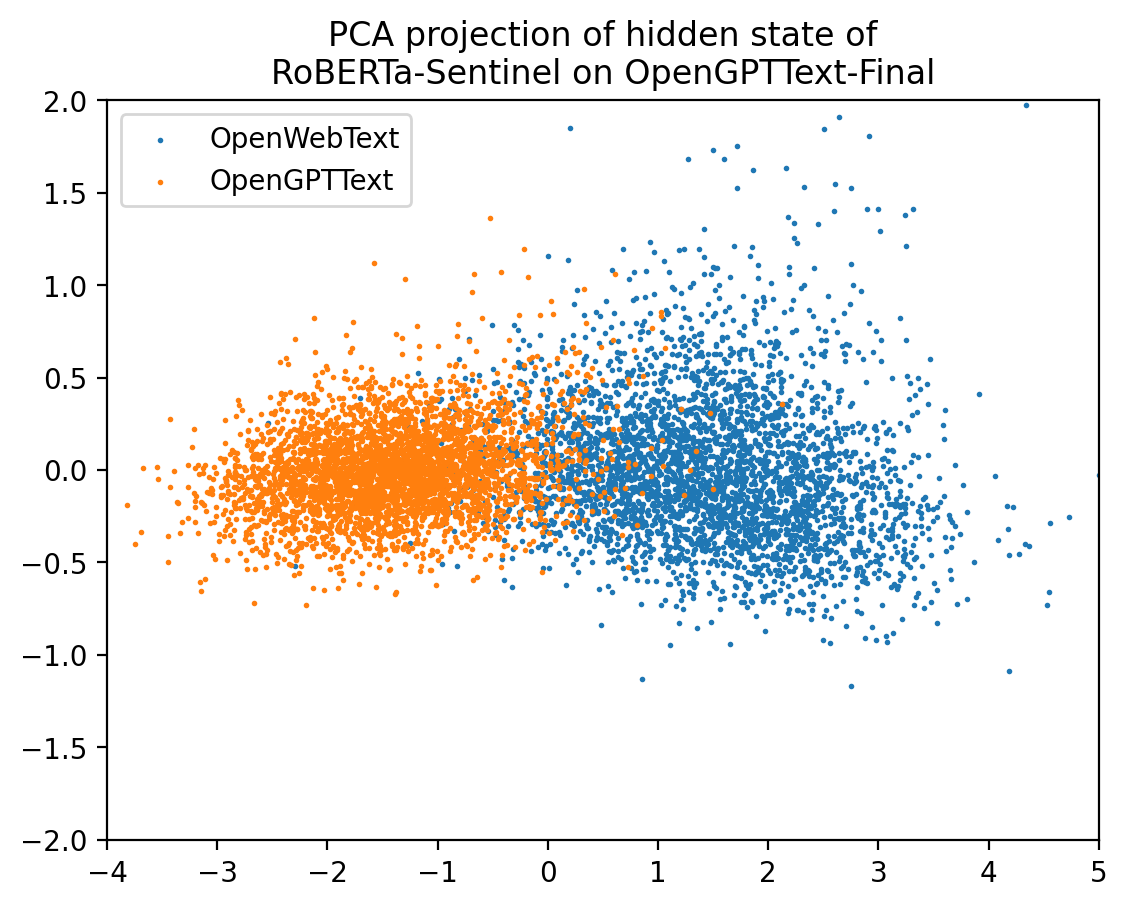

In [36]:
setattr(pca_analysis, "core", None)
pca_analysis(
    cM_cD_hiddens, 
    title="PCA projection of hidden state of\nRoBERTa-Sentinel on OpenGPTText-Final",
    output="roberta_pca_projection_CMCD.pdf",
    x_range=(-4, 5),
    y_range=(-2, 2)
)

## Clean on Dirty PCA Analysis

In [37]:
clean_on_dirty_cache = Path(PATH_CACHE, "clean_model_dirty_data_hidden.pt")

if clean_on_dirty_cache.exists():
    print("Cache Hit! Using existing cache")
    cM_dD_preds, cM_dD_hiddens = torch.load(clean_on_dirty_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    cM_dD_preds, cM_dD_hiddens = dict(), dict()
    for index in tqdm(range(len(dirty_dataset))):
        (text, label), (uid, _) = dirty_dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = clean_model(text)
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()
        cM_dD_preds[uid] = pred
        cM_dD_hiddens[uid] = hidden
    torch.save([cM_dD_preds, cM_dD_hiddens], clean_on_dirty_cache)

Cache Hit! Using existing cache


(3684, 768) (3684, 768)


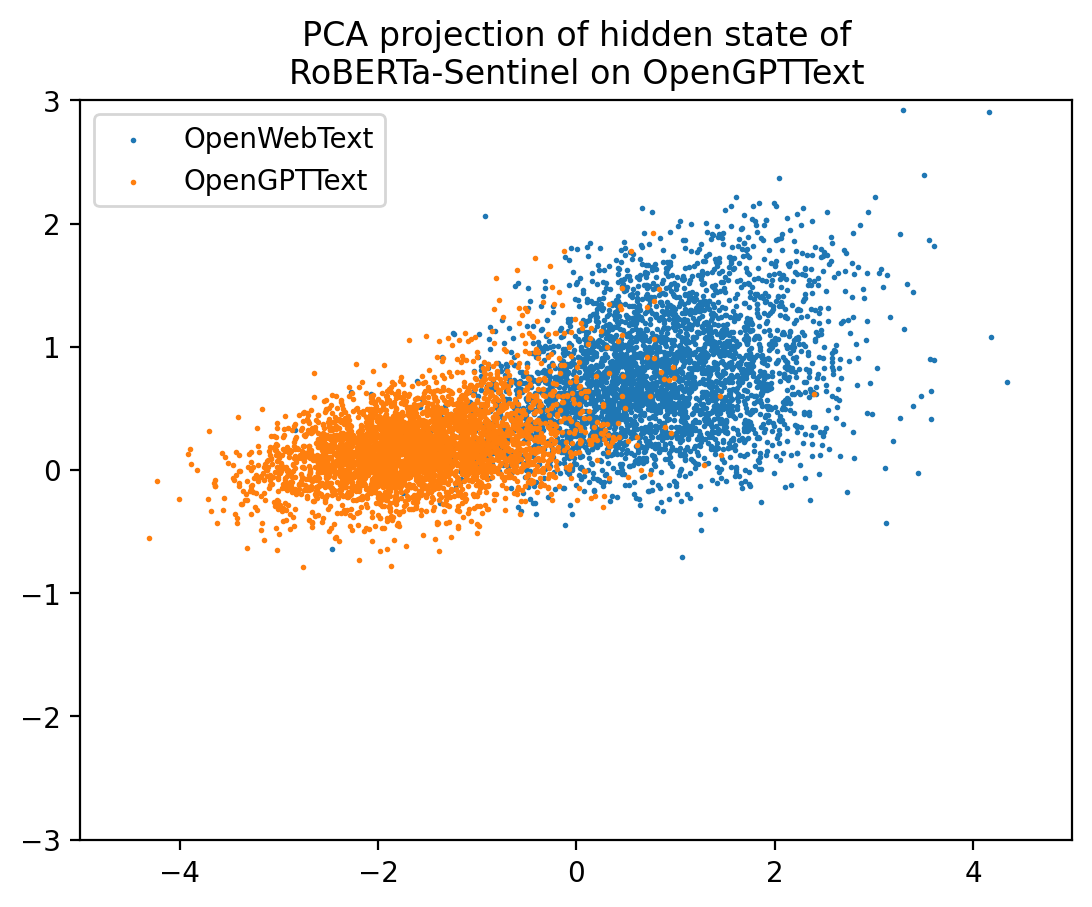

In [38]:
pca_analysis(
    cM_dD_hiddens, 
    title="PCA projection of hidden state of\nRoBERTa-Sentinel on OpenGPTText",
    output="roberta_pca_projection_CMDD.pdf",
    x_range=(-5, 5),
    y_range=(-3, 3)
)

## Dirty on Clean PCA Analysis

In [39]:
del clean_model
torch.cuda.empty_cache()

In [40]:
dirty_model = SentinelNonLinear(
    RobertaModel.from_pretrained("roberta-base"),
    RobertaTokenizer.from_pretrained("roberta-base"),
    ret_hidden=True
)
dirty_model.load_state_dict(dirty_checkpoint["model"])
dirty_model = dirty_model.to("cuda")
dirty_model.eval()

print("Model Loaded")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Loaded


In [41]:
dirty_on_clean_cache = Path(PATH_CACHE, "dirty_model_clean_data_hidden.pt")

if dirty_on_clean_cache.exists():
    print("Cache Hit! Using existing cache")
    dM_cD_preds, dM_cD_hiddens = torch.load(dirty_on_clean_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    dM_cD_preds, dM_cD_hiddens = dict(), dict()
    for index in tqdm(range(len(clean_dataset))):
        (text, label), (uid, _) = clean_dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = dirty_model(text)
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()
        dM_cD_preds[uid] = pred
        dM_cD_hiddens[uid] = hidden
    torch.save([dM_cD_preds, dM_cD_hiddens], dirty_on_clean_cache)

Cache Hit! Using existing cache


(3684, 768) (3684, 768)


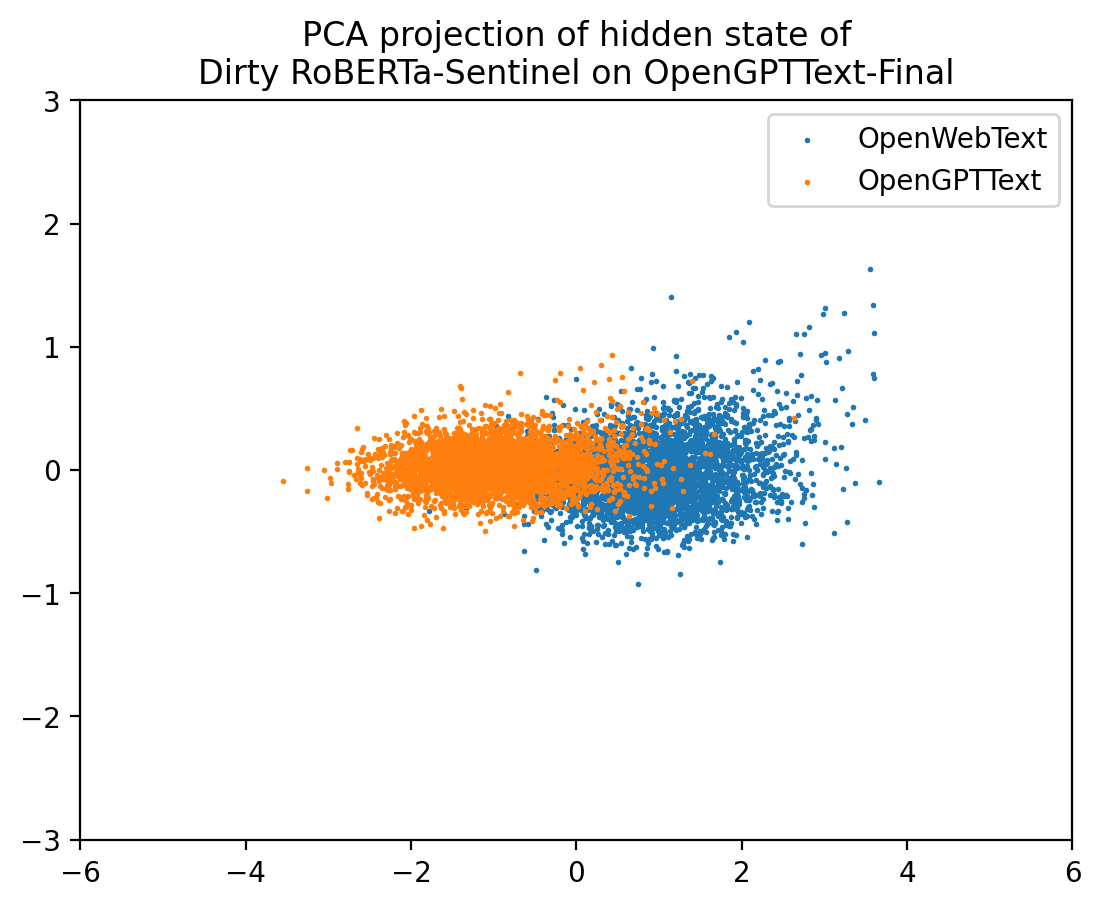

In [42]:
setattr(pca_analysis, "core", None)
pca_analysis(
    dM_cD_hiddens, 
    title="PCA projection of hidden state of\nDirty RoBERTa-Sentinel on OpenGPTText-Final",
    output="roberta_pca_projection_DMCD.pdf",
    x_range=(-6, 6),
    y_range=(-3, 3)
)

## Dirty on Dirty PCA Analysis

In [43]:
dirty_on_dirty_cache = Path(PATH_CACHE, "dirty_model_dirty_data_hidden.pt")

if dirty_on_dirty_cache.exists():
    print("Cache Hit! Using existing cache")
    dM_dD_preds, dM_dD_hiddens = torch.load(dirty_on_dirty_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    dM_dD_preds, dM_dD_hiddens = dict(), dict()
    for index in tqdm(range(len(dirty_dataset))):
        (text, label), (uid, _) = dirty_dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = dirty_model(text)
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()
        dM_dD_preds[uid] = pred
        dM_dD_hiddens[uid] = hidden
    torch.save([dM_dD_preds, dM_dD_hiddens], dirty_on_dirty_cache)

Cache Hit! Using existing cache


(3684, 768) (3684, 768)


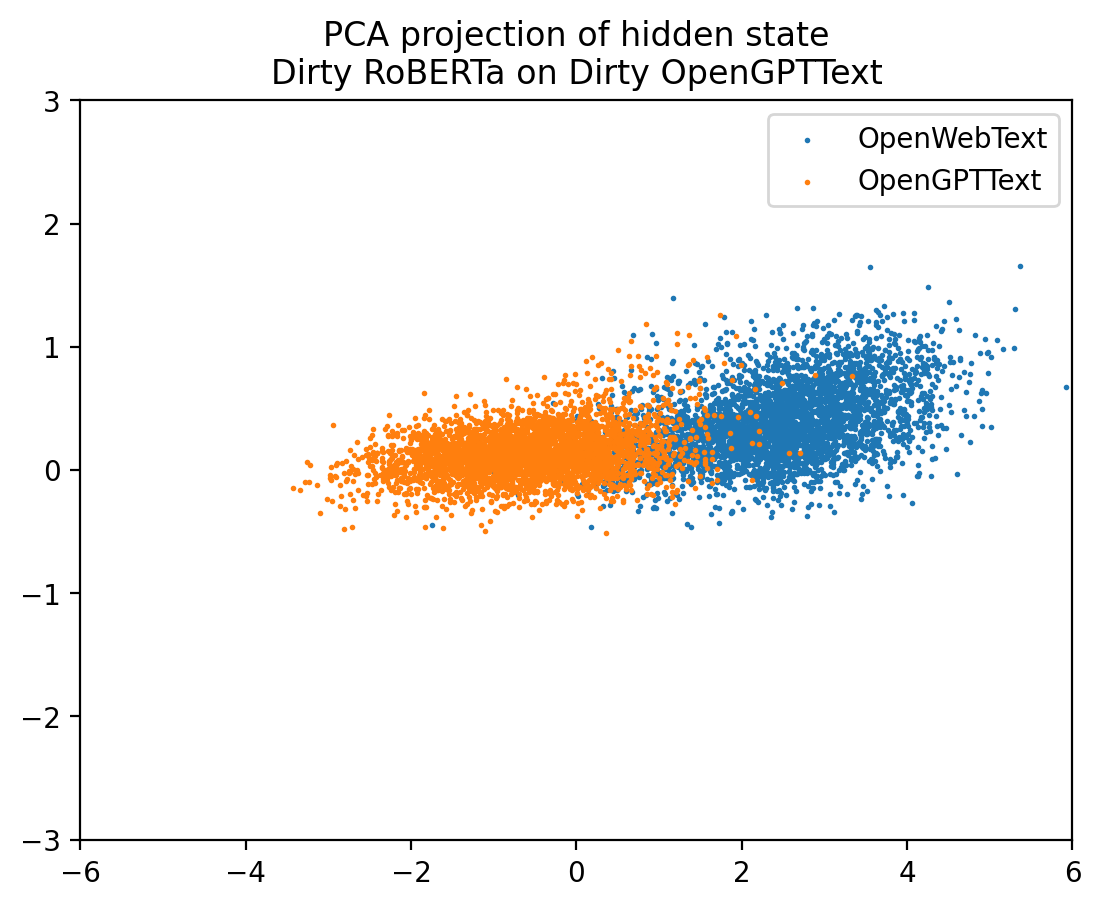

In [50]:
pca_analysis(
    dM_dD_hiddens, 
    title="PCA projection of hidden state\nDirty RoBERTa on Dirty OpenGPTText",
    output="roberta_pca_projection_DMDD.pdf",
    x_range=(-6, 6),
    y_range=(-3, 3)
)

## Jointly Plot PCA for RoBERTa Sentinel on Clean/Dirty Dataset

In [45]:
cd_real_hidden = [cM_cD_hiddens[key] for key in cM_cD_hiddens if key.endswith("-web")]
cd_fake_hidden = [cM_cD_hiddens[key] for key in cM_cD_hiddens if key.endswith("-gpt")]
dd_real_hidden = [cM_dD_hiddens[key] for key in cM_dD_hiddens if key.endswith("-web")]
dd_fake_hidden = [cM_dD_hiddens[key] for key in cM_dD_hiddens if key.endswith("-gpt")]

cd_real_Harray = np.concatenate(cd_real_hidden, axis=0)
dd_real_Harray = np.concatenate(dd_real_hidden, axis=0)
cd_fake_Harray = np.concatenate(cd_fake_hidden, axis=0)
dd_fake_Harray = np.concatenate(dd_fake_hidden, axis=0)

In [46]:
pcaCore = PCA(n_components=2)
pcaCore.fit(np.concatenate([cd_real_Harray, cd_fake_Harray, dd_real_Harray, dd_fake_Harray], axis=0))

PCA(n_components=2)

In [47]:
cd_real_pca = pca_analysis.core.transform(cd_real_Harray)
dd_real_pca = pca_analysis.core.transform(dd_real_Harray)
cd_fake_pca = pca_analysis.core.transform(cd_fake_Harray)
dd_fake_pca = pca_analysis.core.transform(dd_fake_Harray)

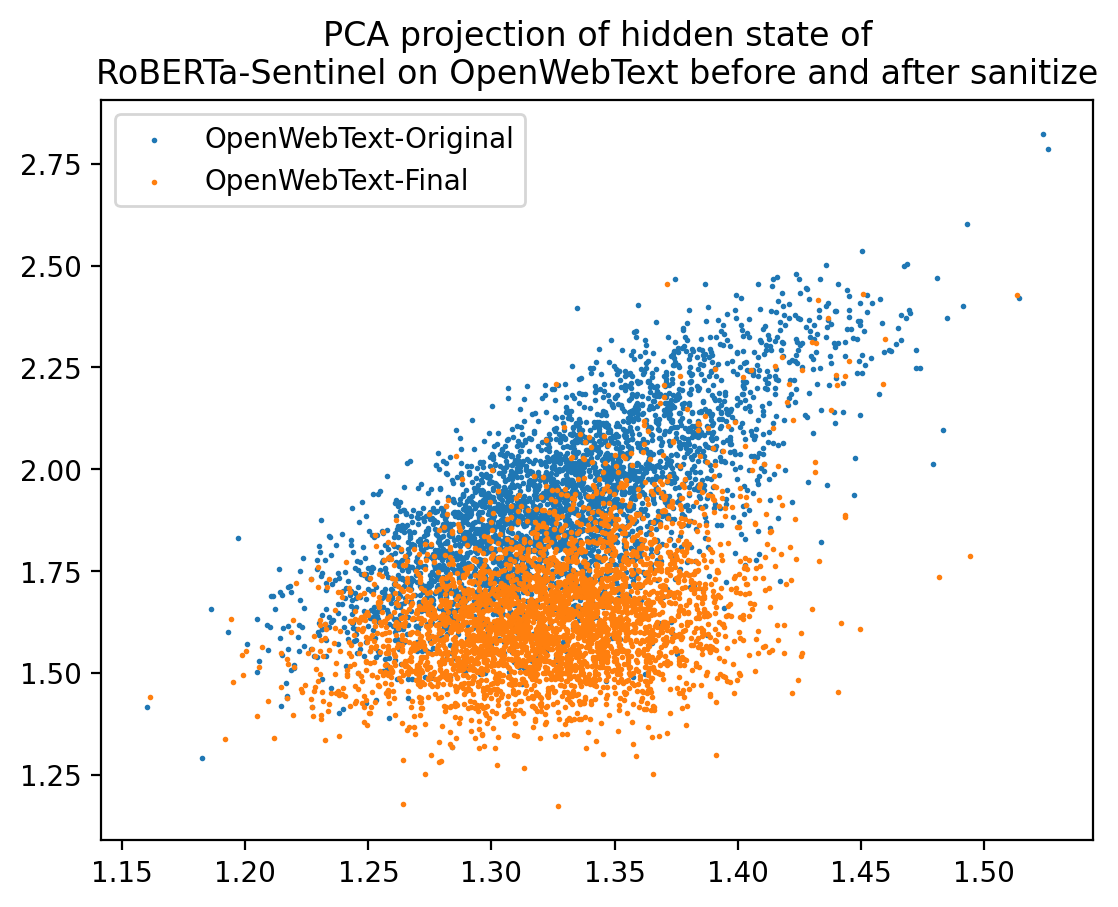

In [48]:
plt.figure(dpi=200)
plt.title("PCA projection of hidden state of\nRoBERTa-Sentinel on OpenWebText before and after sanitize")
plt.scatter(dd_real_pca[:, 0], dd_real_pca[:, 1], label="OpenWebText-Original", s=1)
plt.scatter(cd_real_pca[:, 0], cd_real_pca[:, 1], label="OpenWebText-Final"   , s=1)
# plt.scatter(dd_fake_pca[:, 0], dd_fake_pca[:, 1], label="OpenGPTText (Original)", s=1)
# plt.scatter(cd_fake_pca[:, 0], cd_fake_pca[:, 1], label="OpenGPTText (Sanitize)", s=1)
plt.legend()
plt.savefig(Path(PATH_FIG, "Before_and_after_sanitize_OpenWebText.pdf"))

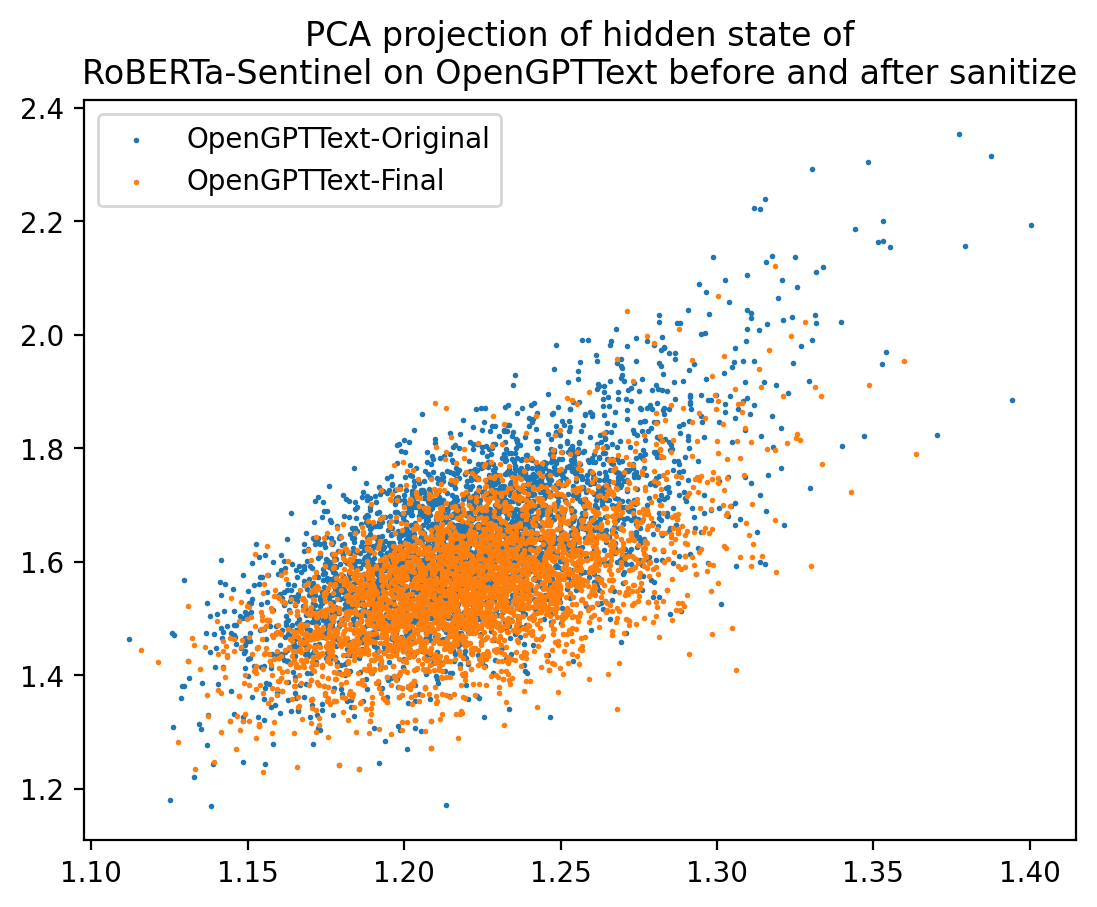

In [49]:
plt.figure(dpi=200)
plt.title("PCA projection of hidden state of\nRoBERTa-Sentinel on OpenGPTText before and after sanitize")
# plt.scatter(dd_real_pca[:, 0], dd_real_pca[:, 1], label="OpenWebText (Original)", s=1)
# plt.scatter(cd_real_pca[:, 0], cd_real_pca[:, 1], label="OpenWebText (Sanitize)", s=1)
plt.scatter(dd_fake_pca[:, 0], dd_fake_pca[:, 1], label="OpenGPTText-Original", s=1)
plt.scatter(cd_fake_pca[:, 0], cd_fake_pca[:, 1], label="OpenGPTText-Final"   , s=1)
plt.legend()
plt.savefig(Path(PATH_FIG, "Before_and_after_sanitize_OpenGPTText.pdf"))